# MNIST Dataset

http://yann.lecun.com/exdb/mnist/

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

from six.moves import xrange

import os
import shutil
from six.moves import urllib
import sys

## Download data

In [2]:
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

datadir = os.path.abspath('./Data')
if not os.path.exists(datadir):
    os.mkdir(datadir)
    
if not os.path.exists(os.path.join(datadir,TRAIN_IMAGES)):
    print('start downloading the data')
    def processbar(filename):
        def _process(count,block_size,total_size):
            per = float(count*block_size)*100/total_size
            if per > 100:
                sys.stdout.write('\r>>downloading {0} 100%\n--downloaed {0}\n'.format(filename))
            else:
                sys.stdout.write('\r>>downloading %s %.1f%%'%(filename,per))          
            sys.stdout.flush()
        return _process
    fname = TRAIN_IMAGES
    surl = SOURCE_URL+fname
    urllib.request.urlretrieve(surl, os.path.join(datadir,fname),processbar(fname))
    
    fname = TRAIN_LABELS
    surl = SOURCE_URL+fname
    urllib.request.urlretrieve(surl, os.path.join(datadir,fname),processbar(fname))
    
    fname = TEST_IMAGES
    surl = SOURCE_URL+fname
    urllib.request.urlretrieve(surl, os.path.join(datadir,fname),processbar(fname))

    fname = TEST_LABELS
    surl = SOURCE_URL+fname
    urllib.request.urlretrieve(surl, os.path.join(datadir,fname),processbar(fname))


# Data Format
The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

The training set contains 60000 examples, and the test set 10000 examples.

## TRAINING SET LABEL FILE (train-labels-idx1-ubyte):

```
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000801(2049) magic number (MSB first) 
0004     32 bit integer  60000            number of items 
0008     unsigned byte   ??               label 
0009     unsigned byte   ??               label 
........ 
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.
```

## TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
```
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000803(2051) magic number 
0004     32 bit integer  60000            number of images 
0008     32 bit integer  28               number of rows 
0012     32 bit integer  28               number of columns 
0016     unsigned byte   ??               pixel 
0017     unsigned byte   ??               pixel 
........ 
xxxx     unsigned byte   ??               pixel
```

The test data is the same as the train data, respectively.

(60000, 28, 28, 1) (60000, 1)


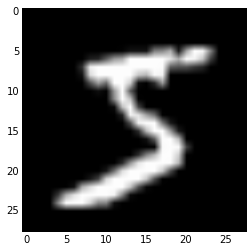

In [3]:
import gzip
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

datadir = os.path.abspath('./Data')
with gzip.GzipFile(datadir+'/'+TRAIN_IMAGES) as f:
    buf = f.read()   
train_magic1,nimg,nrow, ncol= np.frombuffer(buf,np.dtype('>i4'),4)
train_image = np.frombuffer(buf,np.dtype('u1'),offset=16)

with gzip.GzipFile(datadir+'/'+TRAIN_LABELS) as f:
    buf = f.read()   
train_magic2,nlbl = np.frombuffer(buf,np.dtype('>i4'),2)
train_label = np.frombuffer(buf,np.dtype('u1'),offset=8)

assert(train_magic1==2051)
assert(train_magic2==2049)

images = [] # use python list, avoid reallocation when append elements
for i in range(nimg):
    img = train_image[i*nrow*ncol:(i+1)*nrow*ncol].reshape(nrow,ncol)
    images.append(img)

images = np.array(images) # change to np.array

data = images.reshape([-1,28,28,1])/255.0
label = train_label.reshape([-1,1])
print(data.shape,label.shape)
plt.imshow(data[0,:,:,0],cmap='gray')

In [4]:
class DSet(object):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __repr__(self):
        return 'DSet: x:%s, y:%s'%(self.x.shape,self.y.shape)
    
    def __len__(self):
        return len(self.x)
    
class Dataset(object):
    def __init__(self,data,label,per_for_test):
        self._per_for_test = per_for_test
        self._data = data
        self._label = label
        n_test = int(len(self)*self._per_for_test)
        n_train = len(self)-n_test
        idx_train = np.zeros(len(self),dtype=bool)
        idx_train[np.random.choice(np.arange(len(self)),n_train,replace=False)]=True
        
        
        self.train = DSet(self._data[idx_train,:],self._label[idx_train,:])
        self.test = DSet(self._data[~idx_train,:],self._label[~idx_train,:])
        
        self._train_perm = np.arange(len(self.train.x))
        
        self._index_in_epoch = 0
        self._epochs_completed = 0
        
    
    def __len__(self):
        return len(self._data)
    
    # only select batch in training data
    def next_batch(self, batch_size):
        assert batch_size <= len(self.train)
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch>len(self.train.x):
            self._epochs_completed += 1
            perm = np.arange(len(self.train.x))
            self.train.x = self.train.x[perm]
            self.train.y = self.train.y[perm]
            start = 0
            self._index_in_epoch=batch_size
            assert batch_size <= len(self.train)
        end = self._index_in_epoch
        return DSet(self.train.x[start:end], self.train.y[start:end])
    
    def __repr__(self):
        return 'Dataset(data=, label=, per_for_test=%f): <train:(%s-%s);  test:(%s-%s)>' % (
            self._per_for_test,
            str(self.train.x.shape),
            str(self.train.y.shape),
            str(self.test.x.shape),
            str(self.test.y.shape),
        )

mnist = Dataset(data,label,0.20)
print(mnist)
print(mnist.train)

Dataset(data=, label=, per_for_test=0.200000): <train:((48000, 28, 28, 1)-(48000, 1));  test:((12000, 28, 28, 1)-(12000, 1))>
DSet: x:(48000, 28, 28, 1), y:(48000, 1)


# Visualization Toolset

In [5]:
from IPython.display import clear_output, Image, display, HTML
# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


# Softmax regression

In [6]:
import numpy as np
tf.reset_default_graph()

def flatten(feat):
    _shape = feat.get_shape()
    nfeat = np.prod(_shape[1:]).value 
    with tf.variable_scope('flatten'):
        feat = tf.reshape(feat,shape=[-1,nfeat],name='flattened')
    return feat
        
def softmax_classifier(feat, nlabel):
    _shape = feat.get_shape()
    nfeat = np.prod(_shape[1:]).value 
    with tf.variable_scope('fc'):
        W = tf.Variable(tf.zeros([nfeat,nlabel]),name='W')
        b = tf.Variable(tf.zeros([nlabel]),name='b')
        logit = tf.matmul(feat,W)+b
    return logit

def one_hot(target,nlabel):
    with tf.variable_scope('onehot'):
        one_hot_target = tf.one_hot(tf.cast(tf.reshape(target,[-1]),tf.int32),nlabel)
    return one_hot_target

def cross_entropy_loss(logit,onehot):
    with tf.variable_scope('cross_entropy'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logit,onehot))
    return loss

def logit_accuracy(logit,one_hot):
    with tf.variable_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(logit, 1), tf.argmax(one_hot,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    return accuracy
        
graph = tf.Graph()
with graph.as_default():
    feat = tf.placeholder(shape=[None,28,28,1],dtype = tf.float32,name='input')
    flattened_feat = flatten(feat)
    logit = softmax_classifier(flattened_feat,10)
    
    target = tf.placeholder(shape=[None,1],dtype = tf.int64,name='target') 
    onehot_tgt = one_hot(target,10)    
    
    loss = cross_entropy_loss(logit,onehot_tgt)
    accuracy = logit_accuracy(logit,onehot_tgt)
    
graph_def = graph.as_graph_def()
sess = tf.InteractiveSession(graph=graph)

In [7]:
train_op = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
batch_size = 100
epoch = 100
N = len(mnist.train)
maxIter = int(N/batch_size*epoch)
print('total iteration : %d'%maxIter)

sess.run(tf.initialize_all_variables())
testdict = {feat:mnist.test.x.astype(np.float32),target:mnist.test.y.astype(np.int32)}

for i in xrange(3000):
    batch = mnist.next_batch(100)
    batch = {feat:batch.x.astype(np.float32),target:batch.y.astype(np.int32)}
    if i%100 == 0:
        print('%d: loss:%f, accuracy:%f'
              %(i,
                loss.eval(feed_dict=batch),
                accuracy.eval(feed_dict=testdict)))
    sess.run(train_op,feed_dict=batch)

total iteration : 48000
0: loss:2.302585, accuracy:0.099750
100: loss:0.559570, accuracy:0.880167
200: loss:0.267703, accuracy:0.897083
300: loss:0.464257, accuracy:0.896000
400: loss:0.300259, accuracy:0.905250
500: loss:0.153507, accuracy:0.906833
600: loss:0.411640, accuracy:0.909750
700: loss:0.183225, accuracy:0.910250
800: loss:0.233041, accuracy:0.909833
900: loss:0.196567, accuracy:0.911750
1000: loss:0.368646, accuracy:0.914250
1100: loss:0.355865, accuracy:0.911917
1200: loss:0.248110, accuracy:0.914417
1300: loss:0.541352, accuracy:0.913417
1400: loss:0.278069, accuracy:0.915583
1500: loss:0.310415, accuracy:0.916583
1600: loss:0.284143, accuracy:0.912750
1700: loss:0.133175, accuracy:0.908917
1800: loss:0.461406, accuracy:0.916333
1900: loss:0.277702, accuracy:0.916500
2000: loss:0.242792, accuracy:0.914500
2100: loss:0.481660, accuracy:0.913500
2200: loss:0.218076, accuracy:0.917500
2300: loss:0.289748, accuracy:0.912000
2400: loss:0.232344, accuracy:0.904667
2500: loss:0.

In [8]:
show_graph(graph_def)